# Data 620 - Project 3
Baron Curtin, Heather Geiger, Mikhail Groysman, Betsy Rosalen 

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python,
and any features you can think of, build the best name gender classifier you can.

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender
classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are
satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what
you'd expect? 

In [1]:
# library imports
import random
import re
from collections import Counter
from nltk import download
from nltk.corpus import names
from nltk.util import ngrams
from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from nltk import NaiveBayesClassifier
from nltk import DecisionTreeClassifier
from nltk import classify
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Data Loading/Preparation
In the following cells, we will be loading the corpus into memory, labelling all of the names, and then randomizing the
list of names for later use. Randomizing the names will ensure that our training/test sets will contain both genders from 
which we should be able to create numerous features from.

In [2]:
# read in names from the files
# label each name with corresponding gender
# names to be lowercase for easy recognition 
download('names')
males = [(name.lower().strip(), 'male') for name in names.words('male.txt')]
females = [(name.lower().strip(), 'female') for name in names.words('female.txt')]

# combine lists of names
all_names = males + females

# randomize the list
random.seed(5)
random.shuffle(all_names)

[nltk_data] Downloading package names to
[nltk_data]     /Users/betsyrosalen/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

## Feature Creation
Features are the most important part of what goes into a machine learning model. For that reason, it is critically important
to try to come up with features that make the most sense in identifying gender differences in names. To make creation and analysis easier,
we will put our data in a Pandas dataframe.

In [3]:
# create dataframe
data = pd.DataFrame.from_dict(dict(all_names), orient='index', columns=['gender']).reset_index()
data.columns = ['name', 'gender']
data.head()

,name,gender
0,dasi,female
1,marius,male
2,marlene,female
3,margaret,female
4,nickie,male


In [4]:
# instatiate syllable tokenize
SSP = SyllableTokenizer()

# create various feature columns for exploration
data['length'] = data['name'].str.len()
data['first_letter'] = data['name'].str[0]
data['last_letter'] = data['name'].str[-1]
data['vowel_last_letter'] = data['last_letter'].isin([*'aeiou'])
data['vowel_first_letter'] = data['first_letter'].isin([*'aeiou'])
data['vowels'] = data['name'].str.replace(r'[^aeiou]', '')
data['consonants'] = data['name'].str.replace(r'[aeiou]', '')
data['vowel_count'] = data['vowels'].str.len()
data['consonant_count'] = data['consonants'].str.len()
data['bigrams'] = data['name'].apply(lambda x: list(ngrams(x, 2)))
data['trigrams'] = data['name'].apply(lambda x: list(ngrams(x, 3)))
data['syllables'] = data['name'].apply(lambda x: len(SSP.tokenize(x)))

# preview data
data.head()

/Users/betsyrosalen/anaconda3/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))


,name,gender,length,first_letter,last_letter,vowel_last_letter,vowel_first_letter,vowels,consonants,vowel_count,consonant_count,bigrams,trigrams,syllables
0,dasi,female,4,d,i,True,False,ai,ds,2,2,"[(d, a), (a, s), (s, i)]","[(d, a, s), (a, s, i)]",2
1,marius,male,6,m,s,False,False,aiu,mrs,3,3,"[(m, a), (a, r), (r, i), (i, u), (u, s)]","[(m, a, r), (a, r, i), (r, i, u), (i, u, s)]",2
2,marlene,female,7,m,e,True,False,aee,mrln,3,4,"[(m, a), (a, r), (r, l), (l, e), (e, n), (n, e)]","[(m, a, r), (a, r, l), (r, l, e), (l, e, n), (...",3
3,margaret,female,8,m,t,False,False,aae,mrgrt,3,5,"[(m, a), (a, r), (r, g), (g, a), (a, r), (r, e...","[(m, a, r), (a, r, g), (r, g, a), (g, a, r), (...",3
4,nickie,male,6,n,e,True,False,iie,nck,3,3,"[(n, i), (i, c), (c, k), (k, i), (i, e)]","[(n, i, c), (i, c, k), (c, k, i), (k, i, e)]",2


In [5]:
# lets analyze our bigrams and trigrams columns to get the most common ngrams by gender
ngrams_gender = data.groupby('gender')[['bigrams', 'trigrams']].sum()
ngrams_gender['bigrams_counter'] = ngrams_gender['bigrams'].apply(lambda x: Counter(x))
ngrams_gender['trigrams_counter'] = ngrams_gender['trigrams'].apply(lambda x: Counter(x))
ngrams_gender

,bigrams,trigrams,bigrams_counter,trigrams_counter
gender,,,,
female,"[(d, a), (a, s), (s, i), (m, a), (a, r), (r, l...","[(d, a, s), (a, s, i), (m, a, r), (a, r, l), (...","{('d', 'a'): 256, ('a', 's'): 72, ('s', 'i'): ...","{('d', 'a', 's'): 4, ('a', 's', 'i'): 16, ('m'..."
male,"[(m, a), (a, r), (r, i), (i, u), (u, s), (n, i...","[(m, a, r), (a, r, i), (r, i, u), (i, u, s), (...","{('m', 'a'): 147, ('a', 'r'): 345, ('r', 'i'):...","{('m', 'a', 'r'): 49, ('a', 'r', 'i'): 24, ('r..."


Using the counter class and the bigrams and trigrams, we can eliminate the need for the most common bigram/trigram and instead
just use the list of bigrams and trigrams as features. The most common bigram was only in ~13% of the female names and ~12%
of the male names.

## Data Exploration
Lets get a better feel for how our data is composed. In this exploration step, we will confirm whether any of the features
we created will become good predictors of gender. Exploration will occur both visually as well as computationally.

In [6]:
# use our created variables to generate some summary statistics
data.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,vowel_count,consonant_count,syllables
gender,,,,,,
female,6.158750,0.726250,0.174167,2.679792,3.478958,2.479375
male,5.927207,0.235315,0.155676,2.199640,3.727568,2.044685


In [7]:
# separate features from label
X = data.drop(columns=['name', 'gender'])
y = data['gender']

Based on the above chart, we see that females have a higher name length on average, higher vowel counts, and the last letter is 72% of the time a vowel.
These appear to be good predictors. We need to visual confirm what we see numerically

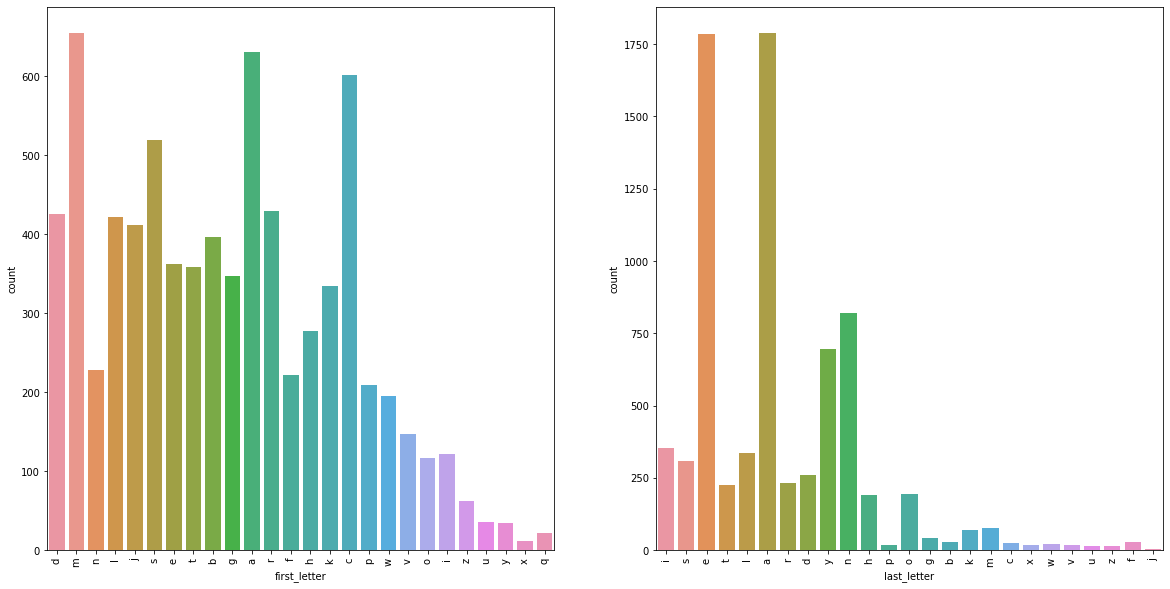

In [8]:
# categorical/numerical columns
categorical_cols = X.loc[:, [col for col in X.columns if 'gram' not in col]].select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for var, subplot in zip(categorical_cols[:2], ax.flatten()):
    sns.countplot(x=var, data=data, ax=subplot)
    # rotate labels for easy viewing
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

The distributions above don't tell us much. We need to condition on gender.

/Users/betsyrosalen/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


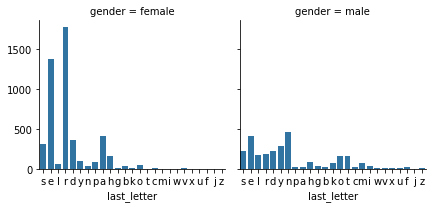

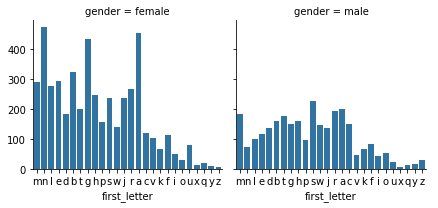

In [9]:
cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'last_letter').add_legend()
plt.tight_layout()
plt.show()

cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'first_letter').add_legend()
plt.tight_layout()
plt.show()

It would appear that both the first and the last letter could be pretty good predictors for gender.

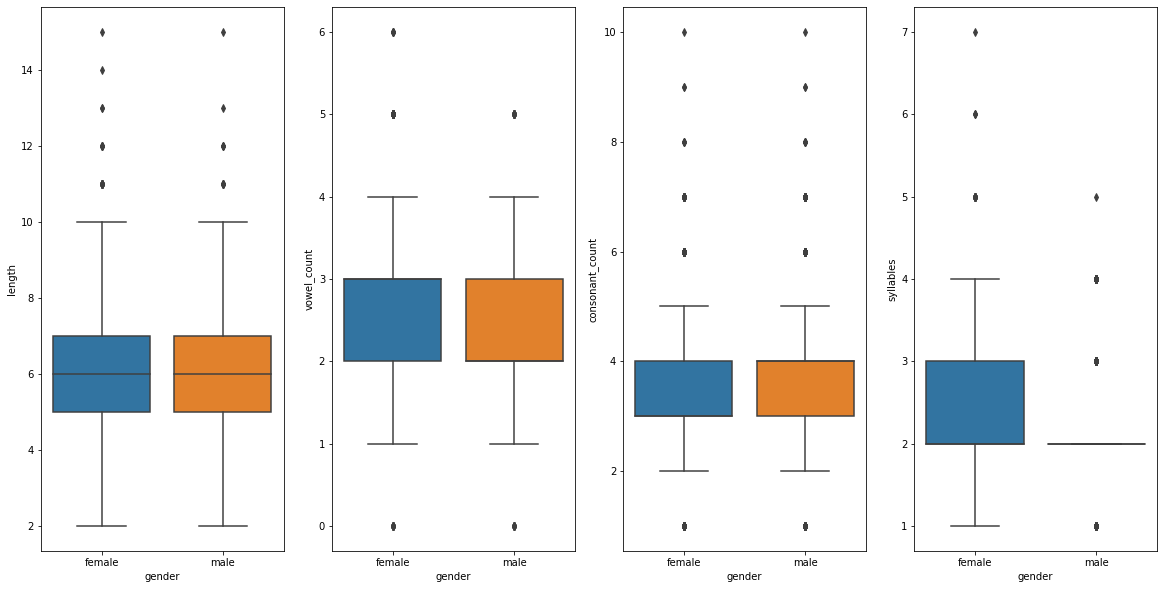

In [10]:
# numerical columns to gender exploration
fig, ax = plt.subplots(1, 4, figsize=(20, 10))

for var, subplot in zip(numerical_cols, ax.flatten()):
    sns.boxplot(x='gender', y=var, data=data, ax=subplot)
    

From the boxplots above, we can safely rule out vowel count, consonant count, and length as strong predictors of gender.  Syllables, however, seems like it may be a good predictor.

## Feature Generation Function
This function will be applied to our lists of names to create the features that we identified as potential predictors above in our initial model "kitchen sink" approach.  As we refine the model we will also refine this function to include only the features that seem most relevant to our classifier.  Vowel count, consonant count, and length have already been removed since they were found above to have no predictive value.  

In [11]:
# feature generator
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

## Data Preparation
We need to apply our feature generation function to our list of names and then split the lists into training, test, and validation sets.

In [12]:
# apply feature generation function
names = [(gender_features(name), gender) for name, gender in all_names]

# create each set of data
dev_set = names[:1000]
test = names[-6900:]

# split the development set into initial training and test sets
train = dev_set[:500]
dev_test = dev_set[500:]

/Users/betsyrosalen/anaconda3/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))


In order to create error lists later we need to reverse the order and split the data first and then add features to each split.

In [13]:
# create each set of data
dev_set_names = all_names[:2000]
test_names = all_names[2000:]

# split the development set into initial training and test sets
train_names = dev_set_names[:500]
devtest_names = dev_set_names[500:]

# apply feature generation function
test_set = [(gender_features(name), gender) for name, gender in test_names]
train_set = [(gender_features(name), gender) for name, gender in train_names]
devtest_set = [(gender_features(name), gender) for name, gender in devtest_names]

## Decision Tree

### First model - Kitchen sink approach

We start by fitting a decision tree model to our full list of potential features.  The "kitchen sink" approach described in the textbook will give us a baseline model which we will then atempt to refine for greater accuracy.

In [14]:
classifier = DecisionTreeClassifier.train(test_set)

In [15]:
print('Accuracy: %4.2f' % classify.accuracy(classifier, devtest_set))

Accuracy: 0.62


Our accuracy was not too bad for a first attempt, but we wanted to do better so took a look at the errors to see if there were any obvious patterns.

In [16]:
def error_list(devtest_names, feature_extractor):
    errors = []
    for (name, tag) in devtest_names:
        guess = classifier.classify(feature_extractor(name))
        if guess != tag:
            errors.append((tag, guess, name))
    for (tag, guess, features) in sorted(errors):
        print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, features))
    return errors

errors = error_list(devtest_names, gender_features)

correct=male     guess=female   name=abbey                         
correct=male     guess=female   name=abby                          
correct=male     guess=female   name=abe                           
correct=male     guess=female   name=adair                         
correct=male     guess=female   name=adrian                        
correct=male     guess=female   name=adrick                        
correct=male     guess=female   name=adrien                        
correct=male     guess=female   name=agustin                       
correct=male     guess=female   name=aharon                        
correct=male     guess=female   name=ahmad                         
correct=male     guess=female   name=alan                          
correct=male     guess=female   name=alejandro                     
correct=male     guess=female   name=alessandro                    
correct=male     guess=female   name=alexis                        
correct=male     guess=female   name=alix       

Looking at the errors didn't reveal any obvious patterns but the textbook indicated that the last two letters were a good indicator in addition to just the last letter.  So we added that to our features and removed the bigrams and trigrams since no two lists will be the same and individual bigrams or trigrams are unlikely to be a good indicator since our earlier analysis indicated that there were no particularly common bigrams or trigrams.

### Refine decision tree features - Second model

We refined our feature extractor function by removing bigrams and trigrams and added a new feature, last_two, to indicate the last two letters of the name.

In [17]:
# feature generator 2
def gender_features2(name):
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # last two letters
    last_two = name[-2:]
    
    # vowel/consonants + counts
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'last_two': last_two,
        'vowels': vowels,
        'consonants': consonants,
        'syllables': syllables
    }

According to the textbook, "Each time the error analysis procedure is repeated, we should select a different dev-test/training split, to ensure that the classifier does not start to reflect idiosyncrasies in the dev-test set." So we reshuffled our training data to get a new split for the train and devtest sets.

In [18]:
# shuffle the dev_set_names to get a new split
random.seed(25)
random.shuffle(dev_set_names)

# split the development set into training and test sets
train_names = dev_set_names[:500]
devtest_names = dev_set_names[500:]

# apply feature generation function
test_set = [(gender_features2(name), gender) for name, gender in test_names]
train_set = [(gender_features2(name), gender) for name, gender in train_names]
devtest_set = [(gender_features2(name), gender) for name, gender in devtest_names]

We refit the model using our refined list of potential features.  

In [19]:
classifier2 = DecisionTreeClassifier.train(train_set)

In [20]:
'Accuracy: %4.2f' % classify.accuracy(classifier2, devtest_set)

'Accuracy: 0.61'

Unfortunately our accuracy score went down!  We examined the errors again to see if anything new became evident.

In [21]:
errors = error_list(devtest_names, gender_features2)

correct=male     guess=female   name=abby                          
correct=male     guess=female   name=abe                           
correct=male     guess=female   name=adair                         
correct=male     guess=female   name=adrian                        
correct=male     guess=female   name=adrick                        
correct=male     guess=female   name=agustin                       
correct=male     guess=female   name=aharon                        
correct=male     guess=female   name=ahmad                         
correct=male     guess=female   name=alan                          
correct=male     guess=female   name=aleck                         
correct=male     guess=female   name=alejandro                     
correct=male     guess=female   name=alessandro                    
correct=male     guess=female   name=alexis                        
correct=male     guess=female   name=alfonso                       
correct=male     guess=female   name=alix       

There are a lot of female names that end in vowels misclassified as male names in our new error list.  Having both the last letter and the last two letters as features may not be working to our benefit. We also printed the pseudocode to see what features were most relevant to our tree structure.

In [22]:
print(classifier2.pseudocode(depth=4))

if consonants == ' d': return 'female'
if consonants == '-dmnr': return 'female'
if consonants == '-mnr': return 'female'
if consonants == 'b': return 'female'
if consonants == 'bcdr': return 'male'
if consonants == 'bchln': return 'female'
if consonants == 'bcky': return 'female'
if consonants == 'bclrst': return 'female'
if consonants == 'bdhlnr': return 'female'
if consonants == 'bdhr': return 'female'
if consonants == 'bdln': return 'female'
if consonants == 'bdlrt': return 'male'
if consonants == 'bdlry': return 'male'
if consonants == 'bdnr': return 'female'
if consonants == 'bdnrt': return 'male'
if consonants == 'bds': return 'male'
if consonants == 'bfnr': return 'female'
if consonants == 'bglnrt': return 'male'
if consonants == 'bglr': return 'female'
if consonants == 'bhkr': return 'female'
if consonants == 'bhls': return 'female'
if consonants == 'bhmrt': return 'female'
if consonants == 'bhr': return 'female'
if consonants == 'bhv': return 'male'
if consonants == 'bjmn': r

Looking at the the pseudocode, we could see that the consonants feature was the most influential feature in our dataset, but since there are so few names that will have matching lists of consonants this would be overfitting and probably not result in a good accuracy score when applied to new data.  

### Refine decision tree features - Third model

From our analysis above we decided to remove last_letter and consonants from our features.  Through iterative trial and error we also decided to remove vowels and syllables.  Our final feature extractor includes only the first_letter, vowel_first_letter, vowel_last_letter, and last_two features.

In [23]:
# feature generator 3
def gender_features3(name):
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # last two letters
    last_two = name[-2:]
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'vowel_last_letter': vowel_last_letter,
        'last_two': last_two
    }

We needed to reshuffle and re-split the data again.

In [24]:
# shuffle the dev_set_names to get a new split
random.seed(50)
random.shuffle(dev_set_names)

# split the development set into training and test sets
train_names = dev_set_names[:500]
devtest_names = dev_set_names[500:]

# apply feature generation function
test_set = [(gender_features3(name), gender) for name, gender in test_names]
train_set = [(gender_features3(name), gender) for name, gender in train_names]
devtest_set = [(gender_features3(name), gender) for name, gender in devtest_names]

We refit the model again using our further refined list of potential features.  

In [25]:
classifier3 = DecisionTreeClassifier.train(train_set)

In [26]:
'Accuracy: %4.2f' % classify.accuracy(classifier3, devtest_set)

'Accuracy: 0.73'

Our final model resulted in a much improved accuracy in the range of 0.69 to 0.73 depending on the random seeed selected.  

In [27]:
errors = error_list(devtest_names, gender_features3)

correct=male     guess=female   name=abby                          
correct=male     guess=female   name=abe                           
correct=male     guess=female   name=adair                         
correct=male     guess=female   name=adger                         
correct=male     guess=female   name=adrian                        
correct=male     guess=female   name=adrick                        
correct=male     guess=female   name=adrien                        
correct=male     guess=female   name=agustin                       
correct=male     guess=female   name=aharon                        
correct=male     guess=female   name=ahmad                         
correct=male     guess=female   name=aleck                         
correct=male     guess=female   name=alejandro                     
correct=male     guess=female   name=alessandro                    
correct=male     guess=female   name=alexei                        
correct=male     guess=female   name=alfonso    

Error analysis shows another potential feature.  There are many female names ending in elle.  Creating a boolean for this may improve our results.  

In [28]:
print(classifier3.pseudocode(depth=4))

if last_two == 'ae': return 'female'
if last_two == 'ah': 
  if first_letter == 'l': return 'female'
  if first_letter == 'o': return 'male'
  if first_letter == 's': return 'female'
  if first_letter == 't': return 'female'
  if first_letter == 'z': return 'male'
if last_two == 'al': 
  if vowel_first_letter == False: return 'male'
  if vowel_first_letter == True: return 'female'
if last_two == 'am': return 'male'
if last_two == 'an': 
  if first_letter == 'a': return 'male'
  if first_letter == 'c': return 'male'
  if first_letter == 'e': return 'male'
  if first_letter == 'i': return 'male'
  if first_letter == 'm': return 'male'
  if first_letter == 'v': return 'female'
if last_two == 'at': return 'male'
if last_two == 'av': return 'male'
if last_two == 'ay': return 'female'
if last_two == 'bb': return 'male'
if last_two == 'bi': return 'female'
if last_two == 'by': return 'female'
if last_two == 'ca': return 'female'
if last_two == 'ce': 
  if first_letter == 'c': return 'female'


Looking at the pseudocode, we see that we still never go past two levels of nested if statements, but now the last_two is the most relevant feature with the first letter as the most frequent feature in the second depth level of the tree.  

### Refine decision tree features - Fourth model

We tried changing last_two to last_three.  First we revised our feature generator.

In [29]:
# feature generator
def gender_features4(name):
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # last three letters
    last_three = name[-3:]
       
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'vowel_last_letter': vowel_last_letter,
        'last_three': last_three
    }

Then we reshuffled and re-split our development set.

In [30]:
# shuffle the dev_set_names to get a new split
random.seed(75)
random.shuffle(dev_set_names)

# split the development set into training and test sets
train_names = dev_set_names[:500]
devtest_names = dev_set_names[500:]

# apply feature generation function
test_set = [(gender_features4(name), gender) for name, gender in test_names]
train_set = [(gender_features4(name), gender) for name, gender in train_names]
devtest_set = [(gender_features4(name), gender) for name, gender in devtest_names]

Then we refit our model to the new datasets.

In [31]:
classifier4 = DecisionTreeClassifier.train(train_set)

In [32]:
'Accuracy: %4.2f' % classify.accuracy(classifier4, devtest_set)

'Accuracy: 0.66'

Changing the last_two feature to last_three reduced the accuracy of our model significantly, so our prevvious model still seems to be our best.    

In [33]:
print(classifier4.pseudocode(depth=4))

if last_three == 'abe': return 'male'
if last_three == 'ace': return 'female'
if last_three == 'ada': return 'female'
if last_three == 'aid': return 'female'
if last_three == 'ain': return 'male'
if last_three == 'ale': return 'male'
if last_three == 'amy': return 'female'
if last_three == 'ana': return 'female'
if last_three == 'and': 
  if first_letter == 'a': return 'male'
  if first_letter == 'b': return 'male'
  if first_letter == 'g': return 'female'
  if first_letter == 'r': return 'male'
if last_three == 'ane': return 'female'
if last_three == 'ang': return 'male'
if last_three == 'ank': return 'male'
if last_three == 'ann': return 'female'
if last_three == 'any': return 'female'
if last_three == 'ara': return 'female'
if last_three == 'ard': return 'male'
if last_three == 'art': return 'male'
if last_three == 'arv': return 'male'
if last_three == 'asi': return 'female'
if last_three == 'ass': return 'female'
if last_three == 'ati': return 'female'
if last_three == 'aun': retur

Looking at the pseudocode, we see that we still never go past two levels of nested if statements, but now the last_three is the most relevant feature with the tree often never going beyond that depth indicating again that we are overfitting.  

### Classify test data 

In [34]:
'Accuracy: %4.2f' % classify.accuracy(classifier, test_set)

'Accuracy: 0.63'

In [35]:
'Accuracy: %4.2f' % classify.accuracy(classifier2, test_set)

'Accuracy: 0.63'

In [36]:
'Accuracy: %4.2f' % classify.accuracy(classifier3, test_set)

'Accuracy: 0.37'

In [37]:
'Accuracy: %4.2f' % classify.accuracy(classifier4, test_set)

'Accuracy: 0.68'

Surprisingly the last model which uses the last three letters of the name as the main and often sole predictor is the most accurate on the test data.  The third model that we thought was our best is actually the worst performer.  

Looking back at the pseudocode it became clear that the third model relied too heavily on the first letter at depth level 2 and since the data didn't have enough examples, there were many letters missing from the tree leaves.  So there are many dead ends in our model and when faced with new data the model wouldn't know how to classify them.  

By comparison the fourth model relied almost exclusively on the last three letters, and apparently there are patterns in the ending trigram that are repeated often enough that it is a very good predictor.